In [1]:
from SpaceNet import *
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import random
import shapely

In [2]:
#here we import slice ad12l1 as an example, and we have got the celltrek results already
adata_adl = sc.read('../stdata/ad12l1.h5ad')
adata_adl.var_names_make_unique()
sc.pp.normalize_total(adata_adl, target_sum=1e4)
sc.pp.log1p(adata_adl)

sc_adata = sc.read('../scdata/AD/sc_adata_raw.h5ad')
sc_adata.var_names_make_unique()
sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)

df_ck_adl = pd.read_csv('../celltrek/adl_celltreck.csv')
df_ck_adl = df_ck_adl[['cell_type', 'coord_x', 'coord_y']]

In [3]:
adata_adl

AnnData object with n_obs × n_vars = 2374 × 19465
    obs: 'imagerow', 'imagecol', 'abeta', 'abeta_maxnorm'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'log1p'
    obsm: 'spatial'

In [4]:
df_ck_adl

,cell_type,coord_x,coord_y
0,TE As,4265.011066,5784.653555
1,TE As,4161.047198,5732.837566
2,DE As,4233.489818,5760.028144
3,DE As,4178.417002,5775.124171
4,TE As,4200.838036,5736.922717
...,...,...,...
6807,DE Inh,3111.012250,1785.258391
6808,DE Inh,3043.341413,1746.650152
6809,DE Glu,3064.260420,1818.467655
6810,DE Inh,3084.973238,1741.620434


In [5]:
cg, radius = generate_search_range(adata_adl, disease_metric_key='abeta_maxnorm', search_factor=3)

In [6]:
cg

In [7]:
df_ck_adl['isinarea'] = [cg.contains(shapely.Point(x)) for x in df_ck_adl[['coord_x', 'coord_y']].values]

In [8]:
df_in_adl = df_ck_adl[df_ck_adl['isinarea'] == True]['cell_type'].value_counts()
df_total_adl = df_ck_adl['cell_type'].value_counts()
df_sta = pd.DataFrame([df_in_adl, df_total_adl])
df_sta.loc['prop'] = df_sta.iloc[0].div(df_sta.iloc[1])
df_sta = df_sta.sort_values(by='prop', axis=1, ascending=False)
#df_sta.to_csv('../results/adl_ct_enriched_celltrek.csv')

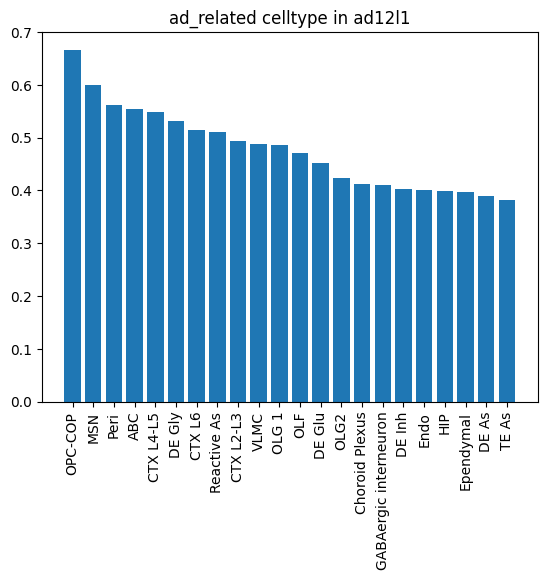

In [9]:
plt.bar(x=df_sta.columns, height=df_sta.loc['prop'])
plt.xticks(rotation=90)
plt.title('ad_related celltype in ad12l1')
plt.show()

In [10]:
adata_adl.obs

,imagerow,imagecol,abeta,abeta_maxnorm
AACACTTGGCAAGGAA-1_4,4207,5758,0.000000,0.000000
AACAGGATTCATAGTT-1_4,2325,5954,0.000000,0.000000
AACAGGTTATTGCACC-1_4,5255,3561,0.000000,0.000000
AACAGGTTCACCGAAG-1_4,2186,6185,0.000000,0.000000
AACCACTGCCATAGCC-1_4,2773,3629,0.000026,0.000135
...,...,...,...,...
TGTTGCGTCCAAGATT-1_4,3795,6216,0.000000,0.000000
TGTTGGAACCTTCCGC-1_4,1820,4311,0.000000,0.000000
TGTTGGAACGAGGTCA-1_4,4317,3542,0.000000,0.000000
TGTTGGATGGACTTCT-1_4,3077,1768,0.000000,0.000000


In [11]:
adata_adl = cal_gene_enrichment(adata_adl, disease_metric_key='abeta', log=False, mode='pcc')

In [12]:
#enriched_genes_adl = cal_enriched_genes(adata_adl, pval_adj=0.05) #select genes with p-value
enriched_genes_adl = cal_enriched_genes(adata_adl, top_g=50, bottom_g=50) # OR select genes with enrichment_score (pcc or z-score)
#enriched_genes_adl.to_csv('adl_abetaenriched_genes.csv') #save your genes enriched in ROI

In [13]:
enriched_genes_adl

,gene_ids,feature_types,genome,gene_enrichment
Gfap,ENSMUSG00000020932,Gene Expression,mm10,0.203981
Tmsb4x,ENSMUSG00000049775,Gene Expression,mm10,0.195697
Pcdhgb4,ENSMUSG00000103585,Gene Expression,mm10,0.189502
Phf11d,ENSMUSG00000068245,Gene Expression,mm10,0.182307
Cst3,ENSMUSG00000027447,Gene Expression,mm10,0.180457
...,...,...,...,...
Tnk2,ENSMUSG00000022791,Gene Expression,mm10,-0.087863
Vtn,ENSMUSG00000017344,Gene Expression,mm10,-0.090980
Tspyl4,ENSMUSG00000039485,Gene Expression,mm10,-0.104358
Mapre2,ENSMUSG00000024277,Gene Expression,mm10,-0.108814


In [14]:
query_result, query_failed = query(protein_list=enriched_genes_adl.index, species='Mus musculus', db_path='../string/', score_threshold=700)
query_result = query_result.reset_index(drop=True)
query_result = cal_genecoexp(adata_adl, query_result)
#query_result.to_csv('abeta_spacenet_adl.csv')

In [15]:
query_result

,node_1,protein1,node_2,protein2,combined_score,coexpef
0,Th,10090.ENSMUSP00000000219,Snca,10090.ENSMUSP00000109907,996.0,0.083408
1,Th,10090.ENSMUSP00000000219,Sst,10090.ENSMUSP00000004480,700.0,-0.053840
2,Th,10090.ENSMUSP00000000219,Gfap,10090.ENSMUSP00000064691,836.0,-0.123771
3,Sst,10090.ENSMUSP00000004480,Agt,10090.ENSMUSP00000066488,823.0,-0.048284
4,Sst,10090.ENSMUSP00000004480,Th,10090.ENSMUSP00000000219,700.0,-0.053840
5,Vtn,10090.ENSMUSP00000017488,Itga9,10090.ENSMUSP00000044227,756.0,0.022409
6,Notch4,10090.ENSMUSP00000015612,Egfl7,10090.ENSMUSP00000158990,765.0,0.054565
7,Notch4,10090.ENSMUSP00000015612,Psenen,10090.ENSMUSP00000044682,788.0,0.010969
8,Ctss,10090.ENSMUSP00000015667,C1qc,10090.ENSMUSP00000036747,706.0,0.173011
9,Elob,10090.ENSMUSP00000066210,Ssrp1,10090.ENSMUSP00000076971,746.0,-0.030730


In [16]:
expression_sums, expression_ratios = calculate_gene_expression_by_celltype(sc_adata, 'cell_type')

In [17]:
expression_ratios

,Astrocyte,Celebellar Neuron,Choroid Plexus,Diencephalic,Ependymal,GABAergic interneuron,Oligodendrocyte,Pallium glutamatergic,Vascular
Xkr4,0.033542,0.078234,0.005511,0.238476,0.004435,0.109041,0.033513,0.476878,0.020369
Gm1992,0.020041,0.068701,0.003204,0.260920,0.001256,0.153274,0.023013,0.460577,0.009015
Gm19938,0.023350,0.068622,0.003950,0.239823,0.002256,0.151770,0.027161,0.469605,0.013464
Gm37381,0.000000,0.000000,0.000000,0.029777,0.781196,0.068208,0.051700,0.022576,0.046543
Rp1,0.026835,0.035526,0.000000,0.099961,0.577912,0.040220,0.004627,0.129777,0.085142
...,...,...,...,...,...,...,...,...,...
Gm50416,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Olfr1504,0.000000,0.000000,0.000000,0.697922,0.000000,0.000000,0.000000,0.302078,0.000000
Gm50339,0.000000,0.000000,0.000000,0.371316,0.000000,0.303919,0.000000,0.324765,0.000000
Gm50186,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [18]:
selected_genes = list(enriched_genes_adl.index) #select genes enriched in ROI as calcuted before
gene_ct_net = construct_gene_ct_net(expression_ratios=expression_ratios, selected_genes=selected_genes)
#gene_ct_net.to_csv('gene_ct_net.csv')
gene_ct_net

,node1,node2,ratio
0,Vxn,Astrocyte,0.037600
1,Lactb2,Astrocyte,0.052500
2,Rims1,Astrocyte,0.039112
3,Atg4b,Astrocyte,0.054234
4,Etnk2,Astrocyte,0.023541
...,...,...,...
850,Csf1r,Vascular,0.072119
851,Rbm14,Vascular,0.050555
852,Wdr44,Vascular,0.041086
853,Tmsb4x,Vascular,0.073274
